# ***Notebook for creating VAE***

## Loading packages

In [37]:
from typing import *
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
import numpy as np
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
import pandas as pd
sns.set_style("whitegrid")
import math 
import torch
from torch import nn, Tensor
from torch.nn.functional import softplus
from torch.distributions import Distribution
from torch.distributions import Normal
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from functools import reduce
from sklearn.model_selection import train_test_split
from collections import defaultdict
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # setting ignore as a parameter and further adding category
#from google.colab import files # UNCOMMENT IF YOU ARE USING GOOGLE DRIVE
from matplotlib.colors import ListedColormap
#For plotting
from IPython.display import Image, display, clear_output
from sklearn.manifold import TSNE
from torch.distributions import Normal
#!pip install umap-learn
#import umap

## Loading data

### Via drive

Connecting to drive

In [38]:
# UNCOMMENT IF YOU ARE USING GOOGLE DRIVE
#from google.colab import drive
#drive.mount('/content/drive')

Defining path

In [39]:
# UNCOMMENT IF YOU ARE USING GOOGLE DRIVE
#drive_path = 'drive/My Drive/Colab Notebooks/Deep_learning_02456/Project/mouseSleepAnalysis-master/datasetsPaper/'

### Or via local folder

In [40]:
drive_path = 'preprocessed_data/'

Loading and treating data

In [41]:
file_name = "experiment1.npz"
dLoad = np.load(drive_path+file_name)

data = dLoad["d"].astype(np.float32)
data_sleepstage = dLoad["epochsLinked"].astype(np.int)
data_sleepstage = data_sleepstage[:,2] #Extracting the sleep stages
obskeys   = dLoad['epochsLinked'].astype(np.float32)
epochTime = dLoad['epochTime']

data = torch.from_numpy(data) #Convert data to tensor
data_sleepstage = torch.from_numpy(data_sleepstage) #Convert data to tensor

no_features = data[0].shape #Det er 11 - data er 11-dimensionelt. 10 kombinationer af bands og 1 EMG.
no_obs = data.shape[0]

#Define batch_size
batch_size = 256
test_batch_size = 256*4

X_train, X_test, y_train, y_test = train_test_split(data,
                                                    data_sleepstage,
                                                    test_size=0.2,
                                                    )
no_obs_train = X_train.shape[0]
no_obs_test = X_test.shape[0]


#index 1 i SS kolonne: Wakefulness
#index 2 i SS kolonne: NREM
#index 3 i SS kolonne: REM

# 1)  d (Nx11), N = # of epochs and columns refer to the possible ratios, EMG is the last column 
# 2)  epochsLinked (Nx4), N = number of epochs, columns are
#       a) Column 1 => epoch ID 
#       b) Column 2=>  epoch index 
#       c) Column 3=> SS 
#       d) Column 4 => subject ID 
# 3)  epochTime 
#				a) (Nx3), N = number of epochs and columns: 
#						i) Column 1 => epoch ID
#						ii) Column 2 => recording mode
#						iii) Column 3 => epoch date-time

/var/folders/fk/q49x7w9j6t53t4bvkbj_nkdm0000gp/T/ipykernel_2906/2543215160.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data_sleepstage = dLoad["epochsLinked"].astype(np.int)


## VAE

### Defining reparameterization

In [42]:
class ReparameterizedDiagonalGaussian(Distribution):
    """
    A distribution `N(y | mu, sigma I)` compatible with the reparameterization trick given `epsilon ~ N(0, 1)`.
    """
    def __init__(self, mu: Tensor, log_sigma:Tensor):
        assert mu.shape == log_sigma.shape, f"Tensors `mu` : {mu.shape} and ` log_sigma` : {log_sigma.shape} must be of the same shape"
        self.mu = mu
        self.sigma = log_sigma.exp()
        
    def sample_epsilon(self) -> Tensor:
        """`\eps  ~ N(0, I)`"""
        return torch.empty_like(self.mu).normal_()
        
    def sample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (without gradients)"""
        with torch.no_grad():
            return self.rsample()
        
    def rsample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (with the reparameterization trick) """
        dist = torch.distributions.Normal(self.mu, self.sigma)
        return dist.rsample()
        
    def log_prob(self, z:Tensor) -> Tensor:
        """return the log probability: log `p(z)`"""
        dist = torch.distributions.Normal(self.mu, self.sigma)
        return dist.log_prob(z)

### VAE network structure

In [43]:
class VariationalAutoencoder(nn.Module):
    """A Variational Autoencoder with
    * a Bernoulli observation model `p_\theta(x | z) = B(x | g_\theta(z))`
    * a Gaussian prior `p(z) = N(z | 0, I)`
    * a Gaussian posterior `q_\phi(z|x) = N(z | \mu(x), \sigma(x))`
    """
    
    def __init__(self, input_shape:torch.Size, latent_features:int) -> None:
        super(VariationalAutoencoder, self).__init__()
        
        self.input_shape = input_shape
        self.latent_features = latent_features
        self.observation_features = input_shape[0]
        

        # Inference Network
        # Encode the observation `x` into the parameters of the posterior distribution
        # `q_\phi(z|x) = N(z | \mu(x), \sigma(x)), \mu(x),\log\sigma(x) = h_\phi(x)`
        self.encoder = nn.Sequential(
            nn.Linear(in_features=self.observation_features, out_features=11),
            nn.ReLU(),
            nn.Linear(in_features=11, out_features=8),
            nn.ReLU(),
            # A Gaussian is fully characterised by its mean \mu and variance \sigma**2
            nn.Linear(in_features=8, out_features=2*latent_features) # <- note the 2*latent_features
        )
        
        # Generative Model
        # Decode the latent sample `z` into the parameters of the observation model
        # `p_\theta(x | z) = \prod_i B(x_i | g_\theta(x))`
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_features, out_features=8),
            nn.ReLU(),
            nn.Linear(in_features=8, out_features=11),
            nn.ReLU(),
            nn.Linear(in_features=11, out_features=self.observation_features)
        )
        
        # define the parameters of the prior, chosen as p(z) = N(0, I)
        self.register_buffer('prior_params', torch.zeros(torch.Size([1, 2*latent_features])))
        self.log_sigma = torch.nn.Parameter(torch.tensor([0.]))
        #self.sigma = torch.tensor([1.])
        
    def posterior(self, x:Tensor) -> Distribution:
        """return the distribution `q(x|x) = N(z | \mu(x), \sigma(x))`"""
        
        # compute the parameters of the posterior
        h_x = self.encoder(x)
        mu, log_sigma =  h_x.chunk(2, dim=-1)
        
        # return a distribution `q(x|x) = N(z | \mu(x), \sigma(x))`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def prior(self, batch_size:int=1)-> Distribution:
        """return the distribution `p(z)`"""
        prior_params = self.prior_params.expand(batch_size, *self.prior_params.shape[-1:])
        mu, log_sigma = prior_params.chunk(2, dim=-1)
        
        # return the distribution `p(z)`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def observation_model(self, z:Tensor) -> Distribution:
        """return the distribution `p(x|z)`"""
        f_z = self.decoder(z)
        mu, = f_z.chunk(1, dim=-1)
        log_sigma = self.log_sigma.expand(mu.shape[0],mu.shape[1])
        return ReparameterizedDiagonalGaussian(mu, log_sigma) #Normal(mu, self.log_sigma.exp())
        

    def forward(self, x) -> Dict[str, Any]:
        """compute the posterior q(z|x) (encoder), sample z~q(z|x) and return the distribution p(x|z) (decoder)"""
        
        # flatten the input
        x = x.view(x.size(0), -1)
        
        # define the posterior q(z|x) / encode x into q(z|x)
        qz = self.posterior(x)
        
        # define the prior p(z)
        pz = self.prior(batch_size=x.size(0))
        
        # sample the posterior using the reparameterization trick: z ~ q(z | x)
        z = qz.rsample()
        
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)
        
        return {'px': px, 'pz': pz, 'qz': qz, 'z': z}
    
    
    def sample_from_prior(self, batch_size:int=100):
        """sample z~p(z) and return p(x|z)"""
        
        # degine the prior p(z)
        pz = self.prior(batch_size=batch_size)
        
        # sample the prior 
        z = pz.rsample()
        
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)
        
        return {'px': px, 'pz': pz, 'z': z}


latent_features = 3
vae = VariationalAutoencoder(no_features, latent_features)
print(vae)

VariationalAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=11, out_features=11, bias=True)
    (1): ReLU()
    (2): Linear(in_features=11, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=6, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=11, bias=True)
    (3): ReLU()
    (4): Linear(in_features=11, out_features=11, bias=True)
  )
)


### VAE inference

In [44]:
def reduce(x:Tensor) -> Tensor:
    """for each datapoint: sum over all dimensions"""
    return x.view(x.size(0), -1).sum(dim=1)

class VariationalInference(nn.Module):
    def __init__(self, beta:float=1.):
        super().__init__()
        self.beta = beta
        
    def forward(self, model:nn.Module, x:Tensor) -> Tuple[Tensor, Dict]:
        
        # forward pass through the model
        outputs = model(x)
        
        # unpack outputs
        px, pz, qz, z = [outputs[k] for k in ["px", "pz", "qz", "z"]]
        
        # evaluate log probabilities
        log_px = reduce(px.log_prob(x))
        log_pz = reduce(pz.log_prob(z))
        log_qz = reduce(qz.log_prob(z))
        
        # compute the ELBO with and without the beta parameter: 
        # `L^\beta = E_q [ log p(x|z) ] - \beta * D_KL(q(z|x) | p(z))`
        # where `D_KL(q(z|x) | p(z)) = log q(z|x) - log p(z)`
        kl = log_qz - log_pz
        elbo = log_px - kl # <- your code here
        beta_elbo = log_px - self.beta*kl # <- your code here
        
        # loss
        loss = -beta_elbo.mean()
        
        # prepare the output
        with torch.no_grad():
            diagnostics = {'elbo': beta_elbo, 'log_px':log_px, 'kl': kl, 'log_qz': log_qz, 'log_pz':log_pz}
            
        return loss, diagnostics, outputs
        

Dummy pass

In [45]:
vi = VariationalInference(beta=1.0)
loss, diagnostics, outputs = vi(vae, data[0:batch_size])
print(f"{'loss':6} | mean = {loss:10.3f}, shape: {list(loss.shape)}")
for key, tensor in diagnostics.items():
    print(f"{key:6} | mean = {tensor.mean():10.3f}, shape: {list(tensor.shape)}")

loss   | mean =     15.094, shape: []
elbo   | mean =    -15.094, shape: [256]
log_px | mean =    -14.748, shape: [256]
kl     | mean =      0.347, shape: [256]
log_qz | mean =     -3.403, shape: [256]
log_pz | mean =     -3.749, shape: [256]


### Training

#### Define a plotting function

In [46]:
#Define font
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)


def plot_2d_latents(ax,qz,z,y):
    z = z.to('cpu')
    y = y.to('cpu')
    scale_factor = 2
    batch_size = z.shape[0]
    palette = sns.color_palette()

    labels = ['Wakefulness','NREM','REM']

    colors = ListedColormap(['green', 'orange', 'red'])

    scatter = ax.scatter(z[:, 0], z[:, 1], cmap=colors, c=y)
    ax.legend(handles=scatter.legend_elements()[0], labels=labels)

    ax.set_xlim([-3, 3])
    ax.set_ylim([-3, 3])
    ax.set_aspect('equal', 'box')

def plot_latents(ax, z, y, perplexity=30, early_exaggeration = 12):
    z = z.to('cpu')
    palette = sns.color_palette()
    colors = [palette[l] for l in y]
    z = TSNE(n_components=2,perplexity=perplexity,early_exaggeration=early_exaggeration).fit_transform(z)
    labels = ['Wakefulness','NREM','REM']
    colors = ListedColormap(['green', 'orange', 'red'])
    scatter = ax.scatter(z[:, 0], z[:, 1], cmap=colors, c=y)
    ax.legend(handles=scatter.legend_elements()[0], labels=labels, markerscale=2, loc='upper left')
    ax.grid(False)


def make_vae_plots(vae, x, y, outputs, training_data, validation_data, epoch, tmp_img="tmp_vae_out.png", figsize=(18, 18)): #figsize=(18, 18)
  fig, axes = plt.subplots(2, 2, figsize=figsize, squeeze=False)

  ax = axes[0, 0]
  ax.set_title(r'ELBO: $\mathcal{L} ( \mathbf{x} )$')
  ax.set_xlabel(r'Epochs')
  ax.set_ylabel(r'$\mathcal{L} ( \mathbf{x} )$')
  ax.plot(training_data['elbo'], label='Training',linewidth=8)
  ax.plot(validation_data['elbo'], label='Validation',linewidth=8)
  ax.legend(loc='upper left')
  ax.grid(False)

  # plot the latent samples
  try:
      z = outputs['z']
      if z.shape[1] == 2:
          axes[0,1].set_title(r'Latent Samples $\mathbf{z} \sim q(\mathbf{z} | \mathbf{x})$')
          qz = outputs['qz']
          plot_2d_latents(axes[0, 1], qz, z, y)
      else:
          axes[0, 1].set_title(r'Latent Samples $\mathbf{z} \sim q(\mathbf{z} | \mathbf{x})$ (t-SNE)')
          plot_latents(axes[0, 1], z, y)
  except Exception as e:
      print(f"Could not generate the plot of the latent samples because of exception")
      print(e)

  #Input heatmap
  ax = axes[1, 0]
  ax.set_title(r'Input data')
  s1 = sns.heatmap(x[:100,:], ax = ax)
  s1.set_xlabel('Features')
  s1.set_ylabel('Batch')
  
  #Reconstruction heatmap
  ax = axes[1, 1]
  ax.set_title(r'Reconstruction $\mathbf{x} \sim p(\mathbf{x} | \mathbf{z}), \mathbf{z} \sim q(\mathbf{z} | \mathbf{x})$')
  px = outputs['px']
  x_sample = px.sample().to('cpu')
  s2 = sns.heatmap(x_sample[:100,:], ax = ax)
  s2.set_xlabel('Features')
  s2.set_ylabel('Batch')

  # display
  plt.tight_layout()
  plt.savefig(tmp_img)
  #folder_name = "hand_in" #Name of folder in which the plots for every epoch should be saved # UNCOMMENT IF YOU ARE USING GOOGLE DRIVE
  #new_path = 'drive/My Drive/Colab Notebooks/Deep_learning_02456/Project/Plots/'+folder_name+'/epoch'+str(epoch) #Definition of full destitation path # UNCOMMENT IF YOU ARE USING GOOGLE DRIVE
  #plt.savefig(new_path) # UNCOMMENT IF YOU ARE USING GOOGLE DRIVE
  plt.close(fig)
  display(Image(filename=tmp_img))
  clear_output(wait=True)

  os.remove(tmp_img)

#### Initialisation

In [47]:
# VAE
latent_features = 3
vae = VariationalAutoencoder(no_features, latent_features)

# Evaluator: Variational Inference
beta = 1
vi = VariationalInference(beta=beta)

# The Adam optimizer works really well with VAEs.
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

# define dictionary to store the training curves
training_data = defaultdict(list)
validation_data = defaultdict(list)
training_data_test = defaultdict(list) #MY TESTINGS

epoch = 0
num_epochs = math.floor(no_obs_test/test_batch_size) #Max number of epochs (because of testing) is math.floor(no_obs_test/test_batch_size)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f">> Using device: {device}")

# move the model to the device
vae = vae.to(device)

#Number of iterations in each epoch
no_iter = math.ceil(no_obs_train/batch_size)

>> Using device: cpu


#### Training loop

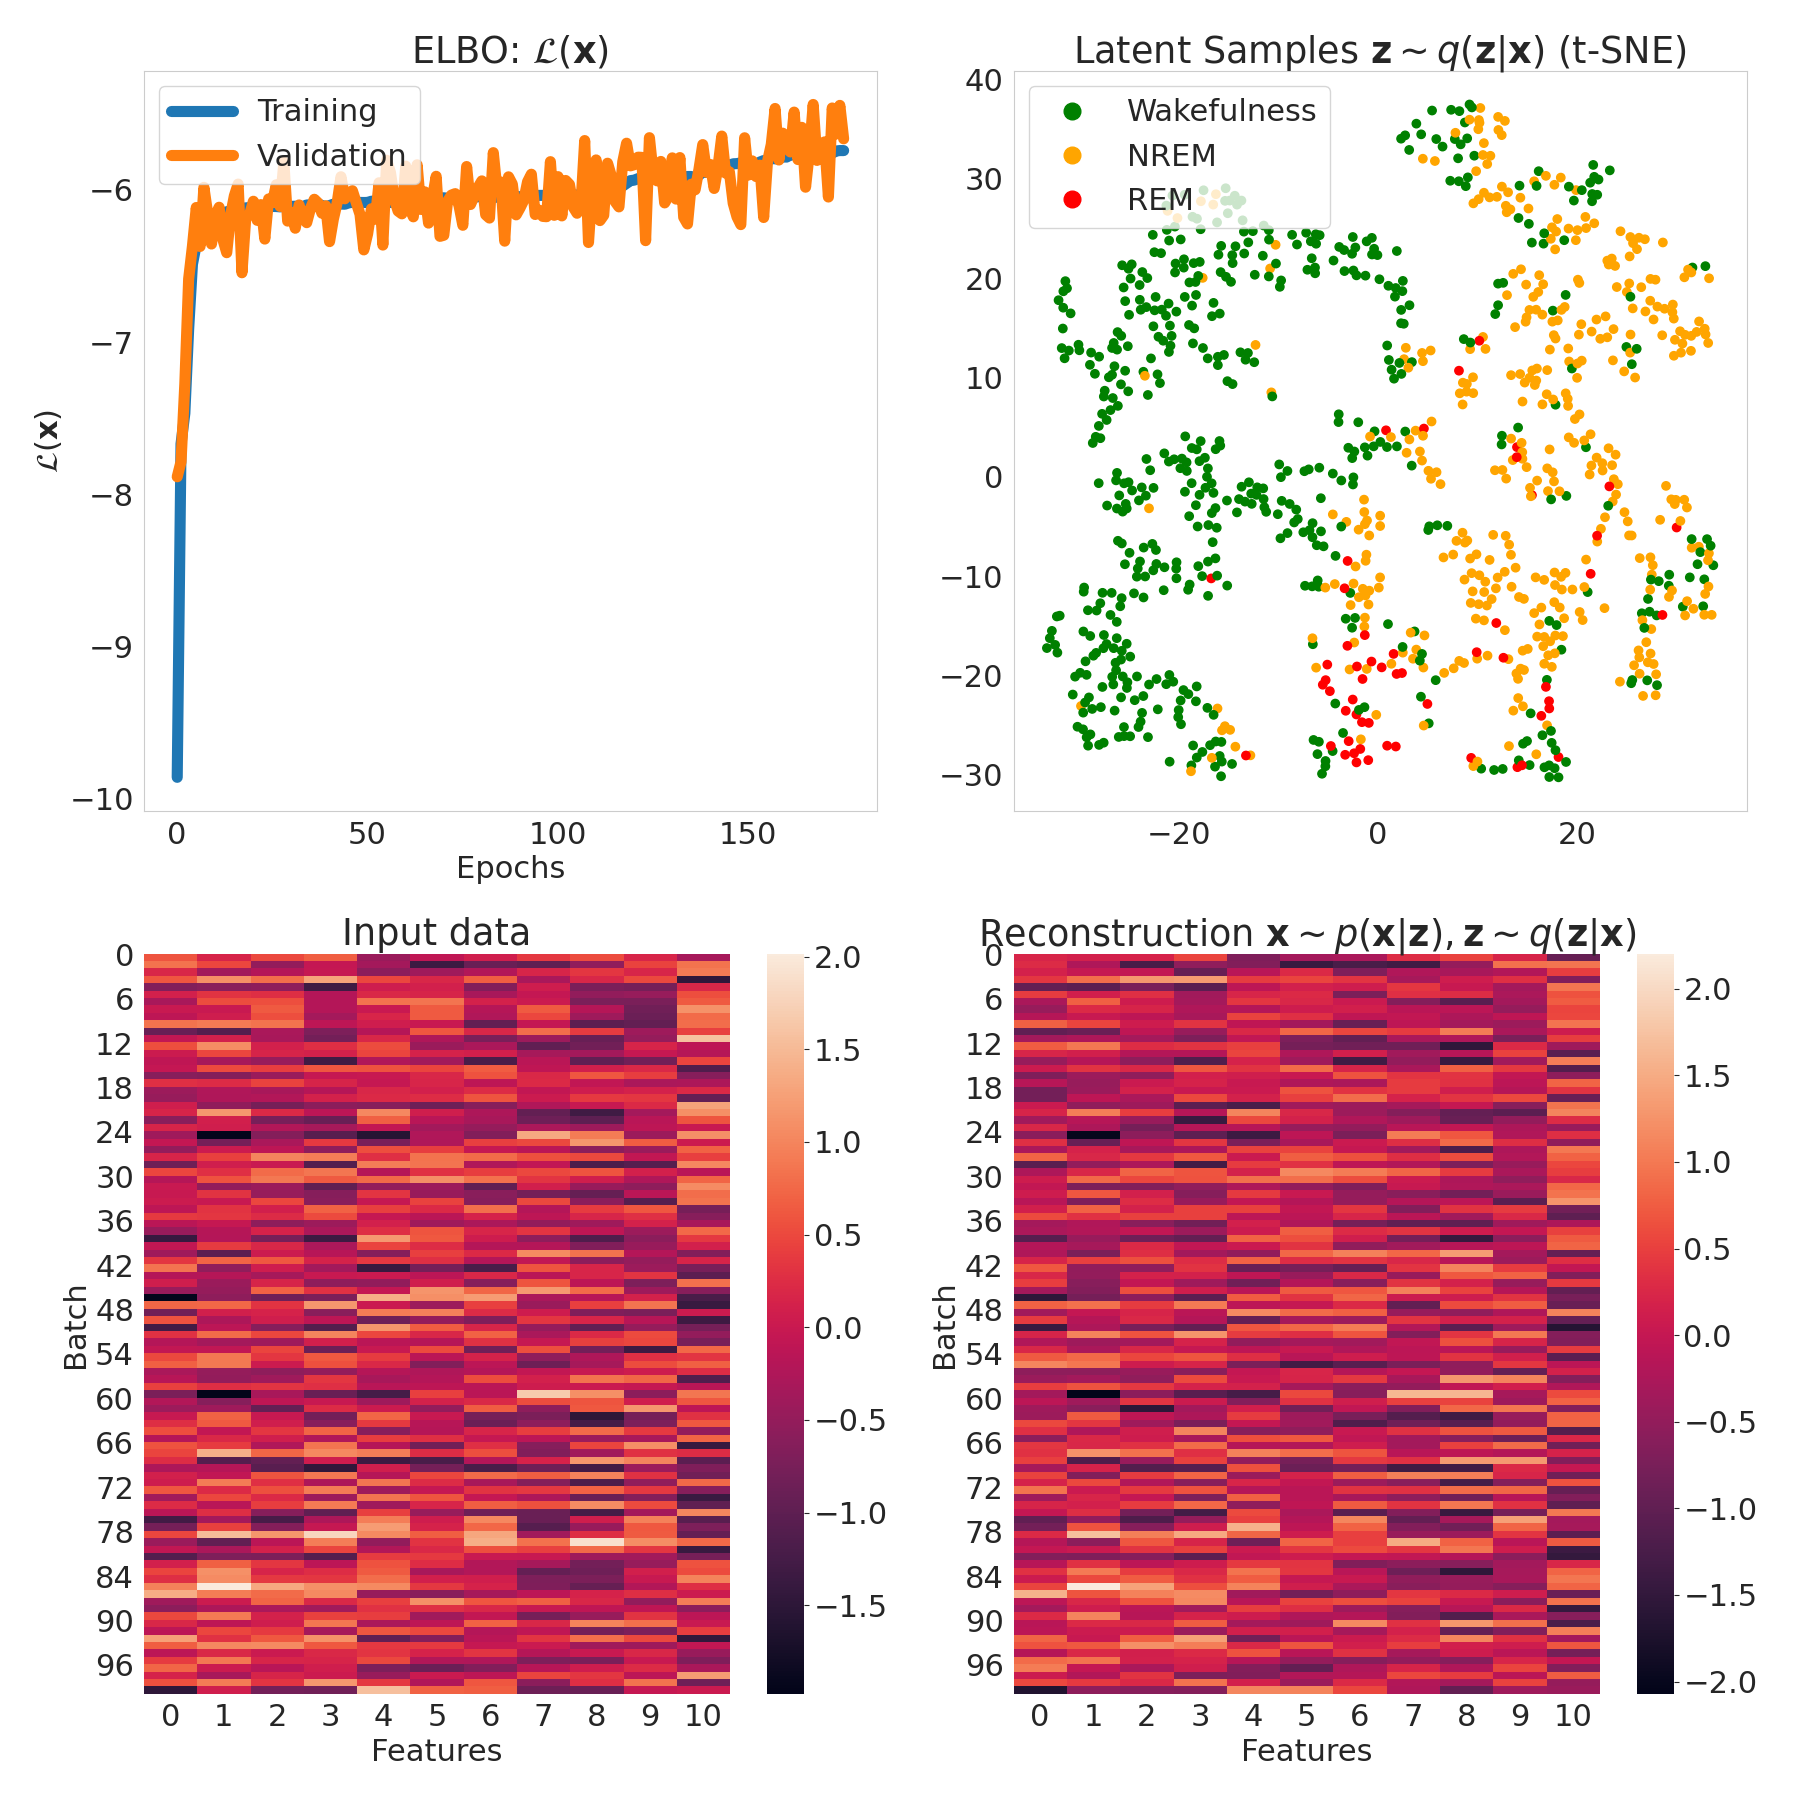

In [48]:
# training..
while epoch < num_epochs:
    #print("Epoch nr.: "+str(epoch))
    training_epoch_data = defaultdict(list)
    vae.train()
    
    for i in range(no_iter):
        #if i%1000 == 0:
          #print("   Batch nr.: "+str(i) + " out of "+ str(no_iter-1))
        x = X_train[i*batch_size:(i+1)*batch_size]

        x = x.to(device)
        
        # perform a forward pass through the model and compute the ELBO
        loss, diagnostics, outputs = vi(vae, x)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # gather data for the current bach
        for k, v in diagnostics.items():
            training_epoch_data[k] += [v.mean().item()]

    # gather data for the full epoch
    for k, v in training_epoch_data.items():
        training_data[k] += [np.mean(training_epoch_data[k])]
        training_data_test[epoch,k] += [np.mean(training_epoch_data[k])]

    # Evaluate on a single batch, do not propagate gradients
    with torch.no_grad():
        vae.eval()
        
        # Just load a single batch from the test loader
        x = X_test[epoch*test_batch_size:(epoch+1)*test_batch_size]
        y = y_test[epoch*test_batch_size:(epoch+1)*test_batch_size]
        x = x.to(device)
        
        # perform a forward pass through the model and compute the ELBO
        loss, diagnostics, outputs = vi(vae, x)
        
        # gather data for the validation step
        for k, v in diagnostics.items():
            validation_data[k] += [v.mean().item()]
    
    make_vae_plots(vae, x, y, outputs, training_data, validation_data, epoch)

    epoch+= 1
    
    